# Прогнозирование числа просмотров объявлений

Автор: Бокиев Наврас <br>
Slack: @bnavras

<img src="https://preview.ibb.co/gKQNPH/photofacefun_com_1524417017.jpg">

#### Импортируем необходимые библиотеки:

In [1045]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import hstack
from pymorphy2 import MorphAnalyzer
from matplotlib import pyplot as plt
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import normaltest, skew, kurtosis
from sklearn.ensemble import RandomForestRegressor
from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso, Ridge

warnings.filterwarnings('ignore')

# Содержание

1. Описание набора данных и признаков
2. Первичный анализ данных
3. Первичный визуальный анализ данных
4. Инсайты и закономерности
5. Выбор метрики
6. Выбор модели
7. Предобработка данных
8. Кросс-валидация и настройка гиперпараметров модели
9. Создание новых признаков и описание этого процесса
10. Построение кривых валидации и обучения
11. Прогноз для отложенной выборке
12. Выводы

# 1. Описание набора данных и признаков

#### Задача: 
Задача проекта - предсказать количество просмотров объявления до конца следующего дня с момента подачи

#### Процесс сбора данных: 
Данные собраны сайтом объявлений Avito. Всего в датасете 423772 объявлений, которые были публикованы с 26 по 28 декабря 2016 года. 
Датасет можно найти на [Boosters](https://boosters.pro/champ_4), либо скачать по [ссылке](https://yadi.sk/d/RY_fdJab3Ue6BK).

#### Ценность задачи:  

Знание количества просмотров может позволить сервису:
- исследовать рынок
- узнать примерную нагрузку на сайт
- оптимизировать сервис
- разместить рекламу на наиболее просматриваемых объявлениях
- выявить объявления, которые наберут небольшое количество просмотров (исследовать причины, предпринять меры) и т.д.


То есть результат поможет сделать сервис лучше!

###  Признаки

- **start_time** - Время подачи объявления (МСК)
- **title** - Заголовок объявления
- **price** - Цена
- **item_id** - Идентификатор объявления
- **owner_type** - Тип владельца объявления
    - *Private* – частный пользователь
    - *Company* – компания
    - *Shop* – владелец магазина на Avito
- **category** - Категория объявления (Транспорт, недвижимость и т.д.)
- **subcategory** - Подкатегория объявления
- **region** - Регион размещения объявления
- **param1**, **param2**, **param3** - Параметры объявления:
    
    На примере подкатегории «Детская одежда и обувь»

    - *param1* = Вид одежды = «Для мальчиков»
    - *param2* = Предмет одежды = “Верхняя одежда»
    - *param3* = Размер = «50-56 cм (0-2 мес)»
    
    
#### Целевая переменная:


`item_views` - количество просмотров объявления

Считаем данные и посмотрим на них:

In [1055]:
data = pd.read_csv('data/task3/train.csv', delimiter=';', index_col=0)  # проверить влияние id, затем удалить
data.head(3)

,start_time,title,price,item_id,owner_type,category,subcategory,param1,param2,param3,region,item_views
id,,,,,,,,,,,,
0,2016-12-27 10:38:04,Сандали фирмы Crocs,800,1301822498390501359,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Москва,27
1,2016-12-27 15:23:55,Бутсы футбольные Reebok,2000,4439620035274845039,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Омская область,9
2,2016-12-28 19:34:15,Nike hypervenom Бутсы,600,4860577743813309218,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Санкт-Петербург,105


# 2. Первичный анализ данных

#### Взаимодействия признаков и их влияние на количесто просмотров 

Посмотрим основные статистические характеристики вещественных признаков:

In [1047]:
data[['price', 'item_views']].describe()

,price,item_views
count,4.237720e+05,423772.000000
mean,1.312350e+06,60.310087
std,6.966541e+08,113.971829
min,0.000000e+00,0.000000
25%,5.000000e+02,14.000000
50%,2.000000e+03,28.000000
75%,9.990000e+03,59.000000
max,4.534535e+11,4140.000000


Видим, что большинство объявлений не выходит за рамки ста просмотров, при этом максимальное число просмотров равно 4140. Большая разница также между верхней картилью цены и ее максимумом. Возможно, мы имеем дело с выбросами, но вернемся к этому вопросу на этапе фильтрации данных, а пока посмотрим на матрицу корреляций:

In [1048]:
data[['price', 'item_views']].corr()

,price,item_views
price,1.000000,0.000244
item_views,0.000244,1.000000


**Вывод**: переменные слабо связаны.

Среди объявлений есть с ценой, равной нулю. Это, как правило, либо вакансии, либо желание людей избавиться от каких-то вещей, домашних животных.

In [1049]:
data[data.price == 0].head(4)

,start_time,title,price,item_id,owner_type,category,subcategory,param1,param2,param3,region,item_views
id,,,,,,,,,,,,
63,2016-12-27 16:04:42,Отдам Обувь 37 р,0,3059761462505069349,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Санкт-Петербург,19
84,2016-12-28 14:42:02,Сапоги зимние Ecco Neela 37 размера,0,5899493358443106944,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Москва,20
134,2016-12-28 21:10:01,Отдам домашних котят,0,6570270872259419698,Private,Животные,Кошки,Японский бобтейл,NaN,NaN,Ленинградская область,72
148,2016-12-28 19:08:51,Официант,0,5256738437501017747,Private,Работа,Резюме,Строительство,Сменный график,NaN,Нижегородская область,27


Также посмотрим характеристики других признаков: 

In [1023]:
data.describe(include=['object']) 

,start_time,title,owner_type,category,subcategory,param1,param2,param3,region
count,423772,423772,423772,423772,423772,406622,220506,166075,423772
unique,179915,293336,3,10,51,418,363,1341,84
top,2016-12-28 20:55:30,Платье,Private,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Для автомобилей,Кузов,Москва
freq,19,3880,262354,133935,61785,45724,32172,11559,79447


В данных много категориальных признаков. На данном этапе уже можно сделать некоторые выводы о количестве уникальных  значений, моде каждого признака.

#### Распределение целевого признака

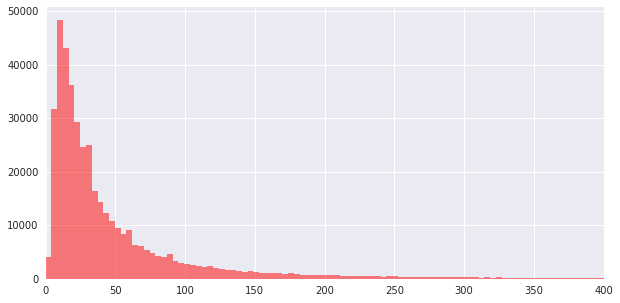

In [1050]:
plt.figure(figsize=(10,5))
plt.xlim(0, 400)
plt.hist(data.item_views, bins=1000, alpha=0.5, color='red', label='true');

Проверим на нормальность и скошенность

In [1052]:
normaltest_result = normaltest(data.item_views)
print(f"{normaltest_result.pvalue}") 

0.0


In [1053]:
print(f"Скошенность: {skew(data.item_views)}")

Скошенность: 7.483337961216911


Мы не будем обучать линейные и метрические модели, поэтому оставим целевую переменную без преобразований

#### Пропуски

In [1054]:
null_count = data.isnull().sum()
null_count[null_count != 0]

param1     17150
param2    203266
param3    257697
dtype: int64

Как видим, пропуски есть только в параметрах. Эти признаки описывают объект объявления. Соответствующие формы могут быть при создании не заполнены, либо товар не описывается какими-либо измерениями. В пользу последнего предположения - возрастание количества пропусков с ростом количества параметров. Заполним пропуски произвольной строкой, непересекающейся с имеющимися признаками.

In [1057]:
data.fillna('Не заполнено');

#### Выбросы

На этапе первичного анализа мы выяснили, что верхняя квантиль цены и количества просмотров не привышают 10000 и 60 соответственно. Но предельные значения этих признаков гораздо больше. На момент исследования на сайте Avito самым дорогим объявлением был земельный участок стоимостью 2 858 076 000 руб. В наших же данных:

In [1024]:
data.price.max()

453453453453

Посмотрим на несколько предельных значений вещественных признаков

In [831]:
sorted(data.price, reverse=True)[:5]

[453453453453, 5677567567, 2762500000, 900000000, 838278000]

In [832]:
sorted(data.item_views, reverse=True)[:5]

[4140, 3761, 3758, 3659, 3330]

Мы не будем удалять выбросы, потому что модели, которые мы собираемся обучать, устойчивы к ним.

# 3. Первичный визуальный анализ данных

Визуализируем для наглядности матрицу корреляций:

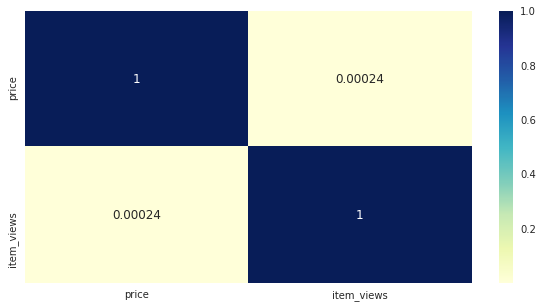

In [851]:
sns.set(rc={"figure.figsize": (10, 5)})
sns.heatmap(data[['price', 'item_views']].corr(), 
            cmap="YlGnBu",
            annot=True);

Теперь давайте исследуем категориальные признаки и выясним, влияет ли каждый признак на количество просмотров. Мы будем вычислять медиану целевого признака для каждого значения.

Начнем с категорий:

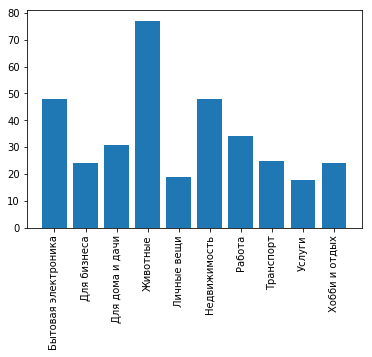

In [345]:
median_target_for_category = data.groupby(['category']).item_views.median()
plt.xticks(rotation=90)
plt.bar(height=median_target_for_category, x=median_target_for_category.index);

Видно, что разные категории набирают разное количество просмотров. Теперь давайте посмотрим на зависимость цены от целевого признака.

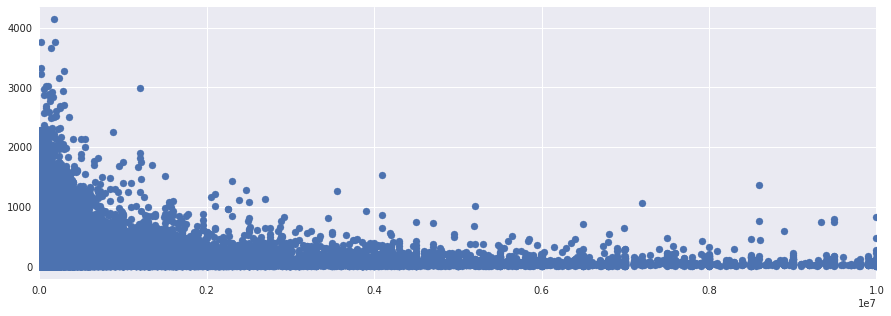

In [919]:
plt.figure(figsize=(15,5))
plt.xlim(0, 10000000)
plt.scatter(data.price, data.item_views);

Чем дороже объект объявления, тем меньше оно набирает просмотров. 

На следующей диаграмме можно увидеть лидеров по количеству объявлений: 

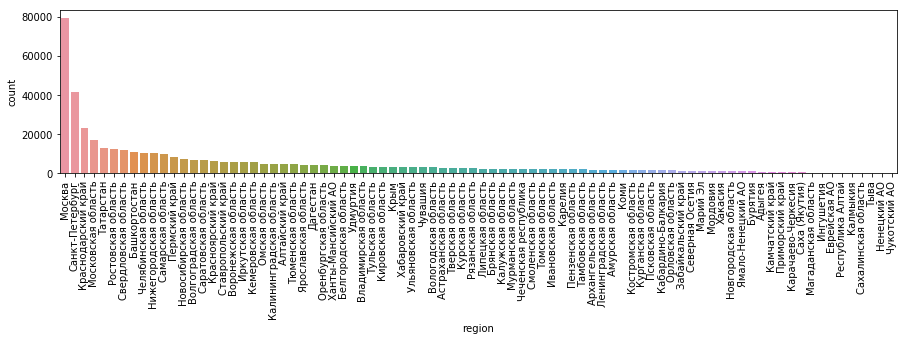

In [341]:
plt.figure(figsize=(15,3))
plt.xticks(rotation=90)
sns.countplot(data=data, x='region', 
              order=data.region.value_counts().index);

Но по количеству просмотров лидероми являются совсем другие регионы:

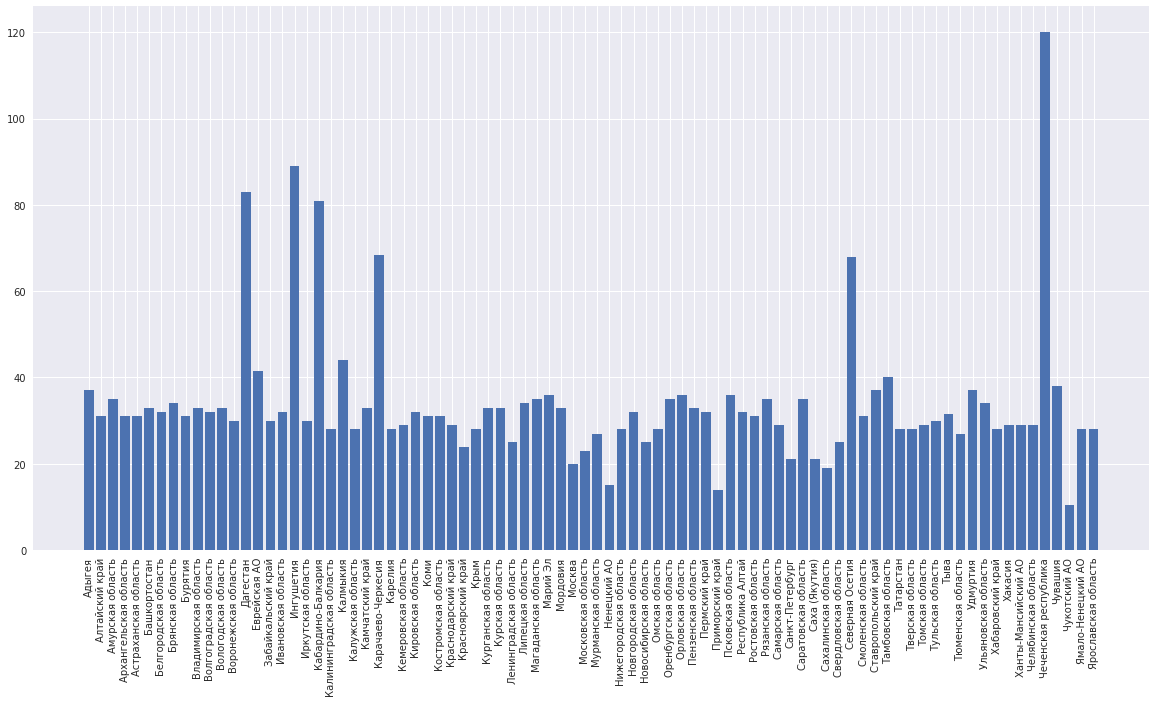

In [1035]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
median_target_for_region = data.groupby(['region']).item_views.median()
plt.bar(height=median_target_for_region,
        x=median_target_for_region.index);

Разное количество просмотров мы можем обнаружить также для подкатегорий и типов собственника

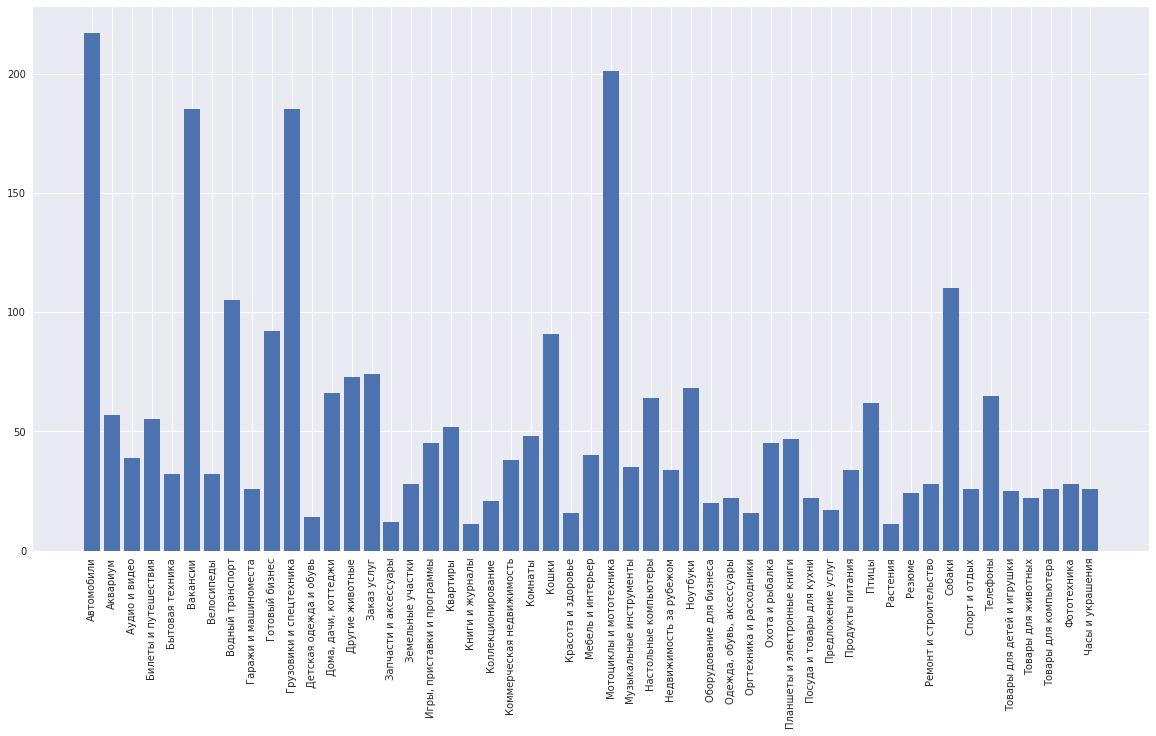

In [1037]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
median_target_for_subcategory = data.groupby(['subcategory']).item_views.median()
plt.bar(height=median_target_for_subcategory, x=median_target_for_subcategory.index);

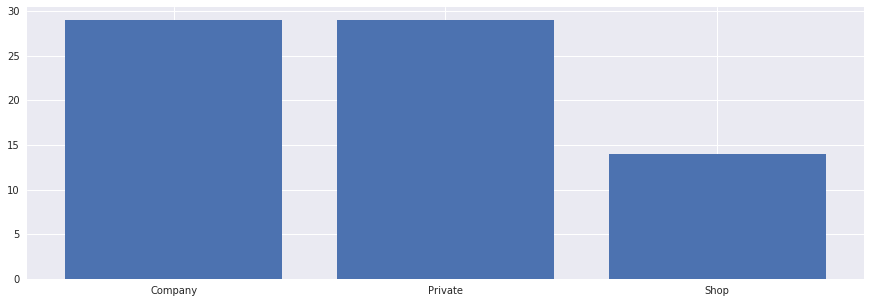

In [931]:
plt.figure(figsize=(15,5))
median_target_for_owner_type = data.groupby(['owner_type']).item_views.median()
plt.bar(height=median_target_for_owner_type, 
        x=median_target_for_owner_type.index);

Медиана для каждого значения категориальных признаков разная. То есть каждая категория таваров имеет определенную спицифику, что влияет на количество просмотров. 

# 4. Инсайты и закономерности

Обобщим некоторые наблюдения:

- Чем дороже объект объявления, тем меньше просмотров оно набирает 
- Лидеры по количеству объявлений(Москва, Санкт-Петербург) и по количеству просмотров(Чеченская республика, Дагестан) не совпадают.
- Больше просмотров набирают объявления категории Животные, чем Личные вещи
- В целом: среднее число просмотров для каждого значения категориального признака ярко отличаются

К инсайтам и закономерностьям мы еще вернемся на этапе создания новый признаков

# 5. Выбор метрики

В процессе исследования я буду считать две метрики:
- Среднеквадратическое отклонение логорифмов
- Среднюю абсолютную ошибку

Первую будем считать, чтобы ориентироваться на лидербор [соревнования](https://boosters.pro/champ_4).


Вторая метрика более простая и очевидная, выражается в тех же измерениях, что и целевая переменная. Отвечает на главный вопрос, на сколько просмотров мы в среднем ошибаемся?

<img src='data/img/CodeCogsEqn.gif'>

In [1058]:
def rmsle(x, y):
    return np.sqrt(np.mean((np.log(x+1)-np.log(y+1))**2))
rmsle_scorer = make_scorer(rmse)

# 6. Выбор модели

Перед нами задача регрессии: cпрогнозировать количество просмотров. Обучать будем следуюшие модели:

- RandomForestRegressor
- XGBoostRegressor

У нас множество категориальных признаков, кроме того данные модели не требуют масштабирования вещественных признаков

# 7. Предобработка данных

In [1098]:
X = data.drop(columns=['item_views'], axis=1)
y = data.item_views

Преобразуем дату в соответствующий тип данных:

In [1099]:
X.start_time = X.start_time.apply(pd.to_datetime)

#### Заменим строки на числа и применим one hot encoder

In [1100]:
def to_ohe(series):
    label_encoder = LabelEncoder()
    one_hot_encoder = OneHotEncoder()
   
    owner_type_train = label_encoder.fit_transform(series)
    return one_hot_encoder.fit_transform(owner_type_train.reshape(-1, 1))

In [1101]:
owner_type_ohe = to_ohe(X.owner_type)
category_ohe = to_ohe(X.category)
region_ohe = to_ohe(X.region)

In [1102]:
param1_ohe = to_ohe(X.param1.astype(str))
param2_ohe = to_ohe(X.param2.astype(str))
param3_ohe = to_ohe(X.param3.astype(str))

#### Bag of words | title

Из заголовка удалим некоторые символы, а слова приведем к нормальной форме. Затем составим мешок из 10000 самых популярых слов

In [1103]:
morph_analyzer = MorphAnalyzer()
def title_preprocess(title):
    title.replace(';', '').replace(',', '')
    return ' '.join([morph_analyzer.normal_forms(word)[0] 
                     for word in title.split()])

In [1104]:
X.title = X.title.apply(title_preprocess)
count_vectorizer = CountVectorizer(max_features=10000)
title = count_vectorizer.fit_transform(X.title)

In [1105]:
price = X.price.values.reshape(-1, 1)

Объединим все признаки:

In [1106]:
X_full = hstack([category_ohe, 
                 owner_type_ohe, 
                 region_ohe, 
                 title,
                 price.reshape(-1,1),
                 param1_ohe,
                 param2_ohe,
                 param3_ohe
                 ])

#### Разобьем данные на обучающую и отложенную части

In [1107]:
X_train, X_holdout, y_train,  y_holdout = train_test_split(X_full.tocsr(), y, test_size=0.3, random_state=17)

# 8. Кросс-валидация

In [1108]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train);

In [1109]:
xgboost = XGBRegressor(n_estimators=5627, 
                      max_depth=10, 
                      subsample=0.9, 
                      colsample_bytree=0.8, 
                      reg_lambda=0, 
                      reg_alpha=2, 
                      learning_rate=0.05, 
                      seed=250)
xgboost.fit(X_train, y_train);

In [1110]:
predict = rf.predict(X_holdout)
rmse(y_holdout, predict)

0.6266308864615694

In [1111]:
predict = xgboost.predict(X_holdout)
rmse(y_holdout, predict)

0.6362502239913187

In [702]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
rf_scores = cross_val_score(estimator=rf,
                         X=X_train_full,
                         y=y_train,
                         cv=skf,
                         scoring=rmse_scorer);

In [1117]:
rf_scores.mean()

0.6315474154655591

In [ ]:
xgb_scores = cross_val_score(estimator=xgboost,
                         X=X_train_full,
                         y=y_train,
                         cv=skf,
                         scoring=rmse_scorer);

In [1119]:
xgb_scores.mean()

0.6406501231918152

# 9. Создание новых признаков

Можно предположить, что объявления с длинным заголовком труднее читать и понимать. Скорее всего они не набирать много просмотров. Давайте создадим этот признак и посмотрим на распределение признака:

In [1075]:
title_len = X.title.apply(len)

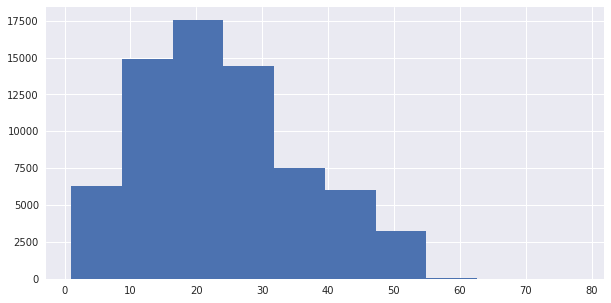

In [970]:
plt.figure(figsize=(10,5))
plt.hist(title_len_train, bins=10);

Действительно, есть некоторый оптимум(то есть не очень короткие и не слишком длинные заголовки), который набирает больше просмотров.

Все объявления в датасете опубликованы в интервале с 26 по 28 декабря 2016 года. То есть в публикации все объявления находились разное время. Логично, что объявления, которые были опубликованы раньше, имели преимущество по времени, за счет чего они могли набрать больше просмотров. Найдем самую позднюю дату и вычислим разницу в секундах для каждого объявления.

In [1087]:
max_date = X.start_time.max()
time = X.start_time.apply(lambda x: (max_date - x).total_seconds())

Добавим сгенерированные признаки, обучим модель и проверим качество прогноза:

In [1088]:
X_full = hstack([X_full,
                 time.values.reshape(-1,1),
                 title_len.values.reshape(-1,1)
                 ])

In [1091]:
X_train, X_holdout, y_train,  y_holdout = train_test_split(X_full.tocsr(), y, test_size=0.3, random_state=17)

In [1093]:
xgboost.fit(X_full, y_train)
rf.fit(X_train, y_train);

In [1095]:
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=5627,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=2, reg_lambda=0, scale_pos_weight=1, seed=250,
       silent=True, subsample=0.9)

In [1097]:
predict = xgboost.predict(X_holdout)
rmse(y_holdout, predict)

0.6350179194572471

In [1096]:
predict = rf.predict(X_holdout)
rmse(y_holdout, predict)

0.623129070577928

Прогноз немного улучшился

# 10. Построение кривых валидации и обучения

Построим кривые валидации и обучения для градиентного бустинга: 

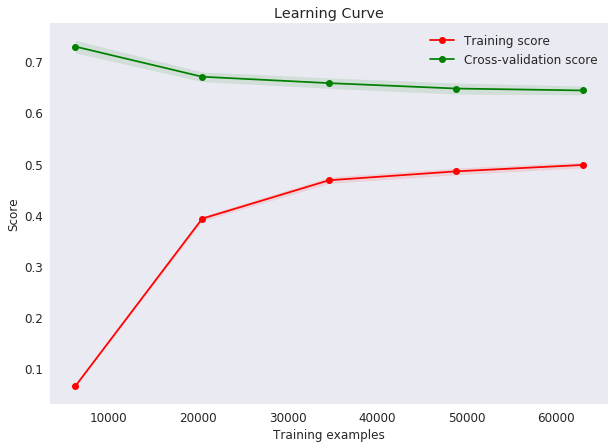

In [935]:
plot_learning_curve(xgboost, X_train_full, y_train, figsize=(10, 7), cv=10, scoring=rmse_scorer);

И для смешанного леса:

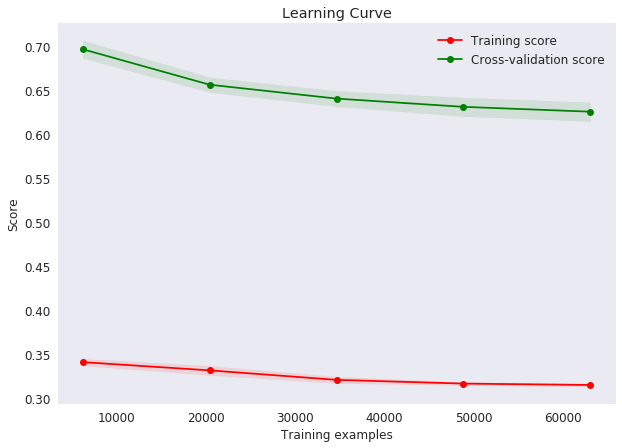

In [940]:
plot_learning_curve(rf, X_train_full, y_train, figsize=(10, 7), cv=10, scoring=rmse_scorer);

Как видим увеличение данных с некоторого порога не приводит к значительному улучшению качества прогноза. Улучшить прогноз можно за счет новых признаков.

# 11. Прогноз для отложенной выборке

Протестируем лучшую модель на отложенной выборке

In [1114]:
predict = rf.predict(X_holdout)

In [1115]:
rmse(y_holdout, predict)

0.6266308864615694

Результат на отложенной выборке сопоставим с результатами на кросс-валидации.

# 12. Выводы

Мы уже говорили о том, что знание количества просмотров может сделать сервис лучше за счет:
- оптимизации сайта 
- размещении рекламы на страницах наиболее просматриваемых объявлений
- устранения причин небольшоего количества просмотров "проблемных" объявлений
- информации о рынке (куда он движется и в какую сторону развиваться сервису?)

Построенную модель могут применять сотрудники Avito для предсказания количества просмотров объявления, и, следовательно, для решения задач, перечисленных выше.

Совершенству нет пределов! Дальнейшие пути улучшения решения: 
- собрать дополнительные признаки об объявлениях
- сгенерировать новые признаки на основе имеющихся
- объединить несколько прогнозных моделей